In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import random

from model import get_train_augmentation_model, get_test_augmentation_model
from model import Patches, PatchEncoder, create_encoder, create_decoder, MaskedAutoencoder
from model import TrainMonitor, WarmUpCosine

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

DATASET = "MNIST"

if DATASET == "CIFAR10":
    from params_CIFAR10 import *
if DATASET == "MNIST":
    from params_MNIST import *


c:\Users\klau\Anaconda3\envs\vit_encoder\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# MNIST

In [2]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1)#.astype("float32") / 255
x_test = np.expand_dims(x_test, -1)#.astype("float32") / 255
TRAIN_VAL_SPLIT = 0.8
TRAIN_VAL_SPLIT_INDEX = int(len(x_train) * TRAIN_VAL_SPLIT)
(x_train, y_train), (x_val, y_val) = (
    (x_train[:TRAIN_VAL_SPLIT_INDEX], y_train[:TRAIN_VAL_SPLIT_INDEX]),
    (x_train[TRAIN_VAL_SPLIT_INDEX:], y_train[TRAIN_VAL_SPLIT_INDEX:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)


Training samples: 48000
Validation samples: 12000
Testing samples: 10000


Index selected: 102.


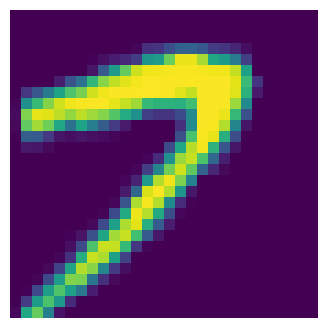

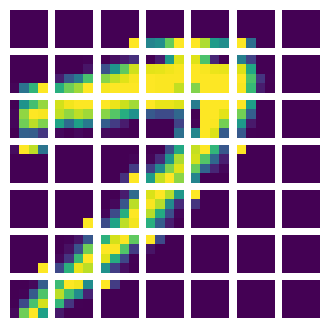

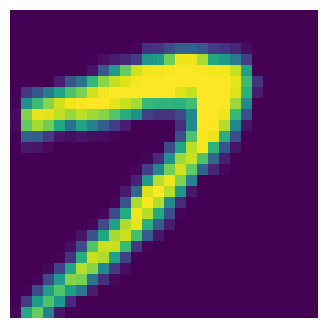

In [3]:
# Visualize the image patches:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model(INPUT_SHAPE, IMAGE_SIZE, resize_pixels=6, apply_rescale=True, apply_flip=False)
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches(PATCH_SIZE, IMAGE_CHANNELS)

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()


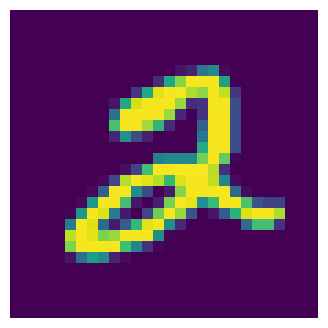

In [4]:
plt.figure(figsize=(4, 4))
plt.imshow(keras.utils.array_to_img(image_batch[179]))
plt.axis("off")
plt.show()

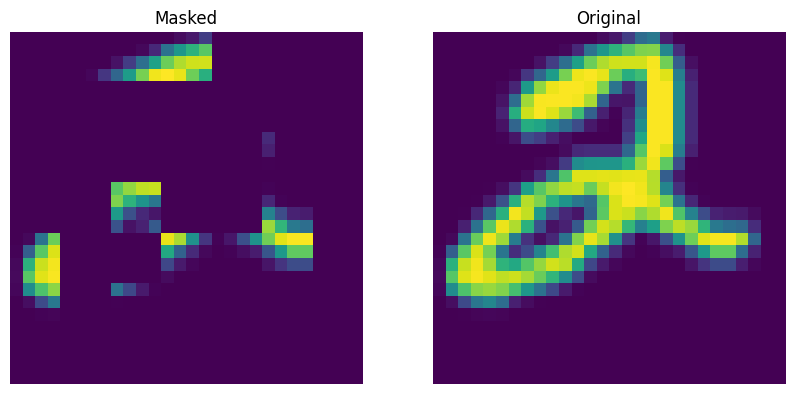

In [5]:
# Visulize the masked image:
# Create the patch encoder layer.
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, 
                             projection_dim=ENC_PROJECTION_DIM, 
                             mask_proportion=MASK_PROPORTION, 
                             img_channels=IMAGE_CHANNELS)

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()


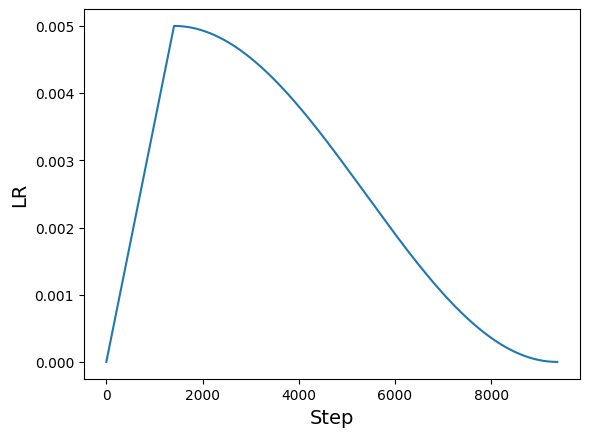

In [6]:
# Test the LR scheduler
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [7]:
train_augmentation_model = get_train_augmentation_model(INPUT_SHAPE, IMAGE_SIZE)
test_augmentation_model = get_test_augmentation_model(IMAGE_SIZE)
patch_layer = Patches(PATCH_SIZE, IMAGE_CHANNELS)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, 
                             projection_dim=ENC_PROJECTION_DIM, 
                             mask_proportion=MASK_PROPORTION,
                             img_channels=IMAGE_CHANNELS)
encoder = create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS, 
                         enc_projection_dim=ENC_PROJECTION_DIM, enc_transformer_units=ENC_TRANSFORMER_UNITS, 
                         norm_eps=LAYER_NORM_EPS)
decoder = create_decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE, img_channels=IMAGE_CHANNELS, num_patches=NUM_PATCHES,
                         enc_projection_dim=ENC_PROJECTION_DIM, dec_projection_dim=DEC_PROJECTION_DIM, dec_transformer_units=DEC_TRANSFORMER_UNITS, 
                         norm_eps=LAYER_NORM_EPS)

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

# Assemble the callbacks.
train_callbacks = [TrainMonitor(next(iter(test_ds)), epoch_interval=5)]

In [8]:
# TRAINING
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, 
    epochs=10, #EPOCHS
    validation_data=val_ds, 
    callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")


Epoch 1/10
 17/188 [=>............................] - ETA: 5:29 - loss: 0.2219 - mae: 0.4076

KeyboardInterrupt: 

### Extracting and using the ViT Encoder part

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)), # or just INPUT_SHAPE
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()


In [ ]:
# Prepare datasets for linear probing
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)


In [ ]:
# Perform linear probing

linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

